# Case 03 - Task 03
Kia Vehicle Reviews Classification and Sentiment Analysis

In [1]:
# Install required packages
!pip install pandas matplotlib seaborn transformers datasets accelerate -U

In [3]:
# Imports
import pandas as pd
import torch
from datasets import Dataset
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    pipeline
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Load Dataset

In [4]:
# Load and verify data
df = pd.read_csv("car_reviews.csv")
print("Original columns:", df.columns.tolist())

# Standardize column name
if 'Review' in df.columns:
    df = df.rename(columns={"Review": "review"})

# Convert to HuggingFace Dataset
dataset = Dataset.from_pandas(df)

Original columns: ['Review']


Analysis of dataset

Token indices sequence length is longer than the specified maximum sequence length for this model (1174 > 1024). Running this sequence through the model will result in indexing errors


TOKEN LENGTH ANALYSIS REPORT
Total rows: 5959

Basic Statistics:
Max tokens: 1204
Min tokens: 2
Mean tokens: 126.0
Median tokens: 116.0
Standard deviation: 105.0
Texts exceeding 512 tokens: 81 (1.36%)

Percentiles:
25th: 67.0 | 50th (median): 116.0
75th: 158.0 | 90th: 183.0
95th: 261.0 | 99th: 606.2600000000002

Frequency Table (Token Ranges):
           Count  Percentage
token_bin                   
0-50        1005        16.9
51-100      1447        24.3
101-200     3042        51.1
201-300      229         3.8
301-400       91         1.5
401-500       61         1.0
501-750       55         0.9
751-1024      19         0.3
1024+          8         0.1

Examples of Long Texts (>512 tokens):

Example 1 (Length: 525 tokens):
--------------------------------------------------
I traded in a 2014 Chrysler 300 and purchased the 2015 premium with the technology and luxury packages with 15k miles.  I was looking at the Buick LaCrosse, Chevy Impala, Azara.  The car is just as roomy as the 3

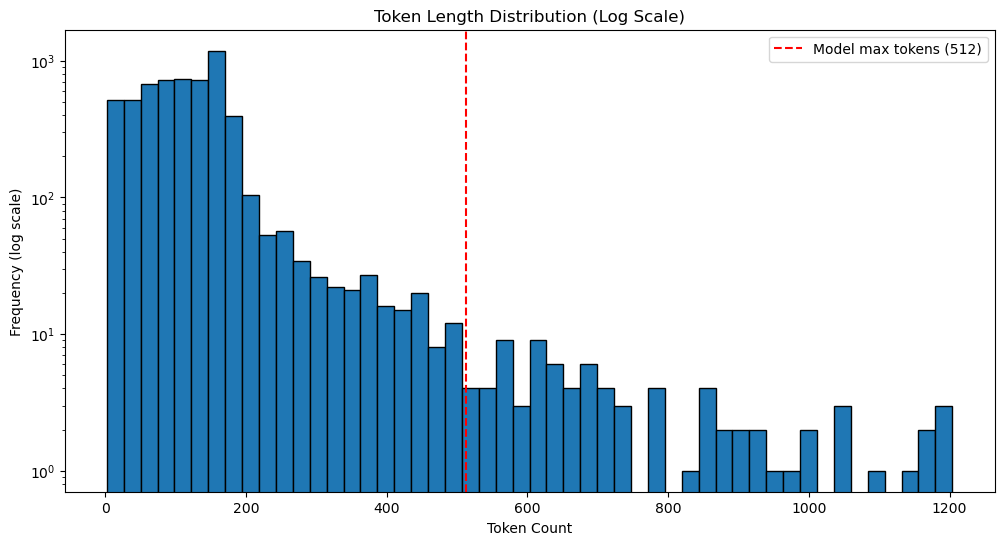

In [12]:
# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-mnli")

# Calculate raw token counts (no truncation)
df["raw_token_count"] = df["review"].apply(
    lambda x: len(tokenizer.tokenize(x))
)

# Analyze token lengths
max_length = df["raw_token_count"].max()
mean_length = df["raw_token_count"].mean()
median_length = df["raw_token_count"].median()
min_length = df["raw_token_count"].min()
std_length = df["raw_token_count"].std()
num_exceeding = (df["raw_token_count"] > 512).sum()

# Percentiles
percentiles = df["raw_token_count"].quantile([0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

# Frequency table for token ranges
bins = [0, 50, 100, 200, 300, 400, 500, 750, 1024, max_length]
labels = ["0-50", "51-100", "101-200", "201-300", "301-400", "401-500", "501-750", "751-1024", "1024+"]
df["token_bin"] = pd.cut(df["raw_token_count"], bins=bins, labels=labels, right=False)
frequency_table = pd.DataFrame({
    "Count": df["token_bin"].value_counts().sort_index(),
    "Percentage": df["token_bin"].value_counts(normalize=True).sort_index().round(3) * 100
})

# Get examples of texts exceeding 512 tokens
long_texts = df[df["raw_token_count"] > 512]["review"].head(5).tolist()

# Print full report
print("="*50)
print("TOKEN LENGTH ANALYSIS REPORT")
print("="*50)
print(f"Total rows: {len(df)}")
print(f"\nBasic Statistics:")
print(f"Max tokens: {max_length}")
print(f"Min tokens: {min_length}")
print(f"Mean tokens: {mean_length:.1f}")
print(f"Median tokens: {median_length}")
print(f"Standard deviation: {std_length:.1f}")
print(f"Texts exceeding 512 tokens: {num_exceeding} ({num_exceeding/len(df)*100:.2f}%)")

print("\nPercentiles:")
print(f"25th: {percentiles[0.25]} | 50th (median): {percentiles[0.5]}")
print(f"75th: {percentiles[0.75]} | 90th: {percentiles[0.9]}")
print(f"95th: {percentiles[0.95]} | 99th: {percentiles[0.99]}")

print("\nFrequency Table (Token Ranges):")
print(frequency_table)

print("\nExamples of Long Texts (>512 tokens):")
for i, text in enumerate(long_texts, 1):
    print(f"\nExample {i} (Length: {len(tokenizer.tokenize(text))} tokens):")
    print("-"*50)
    print(text[:500] + "[...]" if len(text) > 500 else text)  # Show truncated text

# Visualization
plt.figure(figsize=(12, 6))
plt.hist(df["raw_token_count"], bins=50, log=True, edgecolor="black")
plt.axvline(512, color='r', linestyle='--', label='Model max tokens (512)')
plt.title("Token Length Distribution (Log Scale)")
plt.xlabel("Token Count")
plt.ylabel("Frequency (log scale)")
plt.legend()
plt.show()

## Zero-Shot Classification
 We chose facebook/bart-large-mnli because it's a powerful model trained on natural language inference tasks, making it well-suited for zero-shot classification. It allows us to classify text without fine-tuning for specific classes, which is ideal for our task involving review categorization.

While the facebook/bart-large-mnli model supports max_length=1024 tokens, we set max_length=512 to:

    Optimize system performance (lower GPU memory usage, faster inference).

    Minimize data truncation impact (only 1.36% of texts exceed 512 tokens).

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

model = AutoModelForSequenceClassification.from_pretrained("facebook/bart-large-mnli").to(device)
tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-mnli")
candidate_labels = [
    "talks about driving experience",
    "talks about features",
    "talks about value for money",
    "talks about issues",
    "other"
]
# Zero-shot classification with proper pair handling
def classify_batch(batch):
    # Create (review, hypothesis) pairs for all labels
    texts = [review for review in batch['review'] for _ in candidate_labels]
    hypotheses = [f"This example is {label}" for label in candidate_labels for _ in batch['review']]

    # Tokenize all pairs
    inputs = tokenizer(
        texts,
        hypotheses,
        padding='longest',
        truncation=True,
        return_tensors="pt",
        max_length=512
    ).to(device)

    # Process in mixed precision
    with torch.no_grad(), torch.cuda.amp.autocast():
        logits = model(**inputs).logits
        probs = logits[:,[0,2]].softmax(dim=1)[:,0]

    # Reshape to (batch_size, num_labels)
    probs_matrix = probs.reshape(len(batch['review']), len(candidate_labels))
    top_labels = [candidate_labels[i] for i in probs_matrix.argmax(dim=1)]

    return {"talks_about": top_labels}

# Apply with same batch settings
dataset = dataset.map(
    classify_batch,
    batched=True,
    batch_size=32,
    writer_batch_size=1000,
    load_from_cache_file=False
)

## Sentiment Analysis
The cardiffnlp/twitter-roberta-base-sentiment model is trained on tweets and social media data, which makes it ideal for short and informal texts like user reviews. It provides reliable 3-class sentiment classification
*   positive
*   neutral
*   negative


In [6]:
# GPU-accelerated sentiment analysis
sentiment_model = pipeline(
    "text-classification",
    model="cardiffnlp/twitter-roberta-base-sentiment",
    device=0,
    max_length=512,
    tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment", model_max_length=512),
    truncation=True,
    batch_size=32
)

label_map = {
    "LABEL_0": "negative",
    "LABEL_1": "neutral",
    "LABEL_2": "positive"
}

def predict_sentiment(batch):
    results = sentiment_model(batch["review"])
    return {"sentiment": [label_map[r["label"]] for r in results]}

dataset = dataset.map(
    predict_sentiment,
    batched=True,
    batch_size=32
)

Device set to use cuda:0


Map:   0%|          | 0/5959 [00:00<?, ? examples/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


## Analysis & Visualization

<ipython-input-10-c9751f0c4d22>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


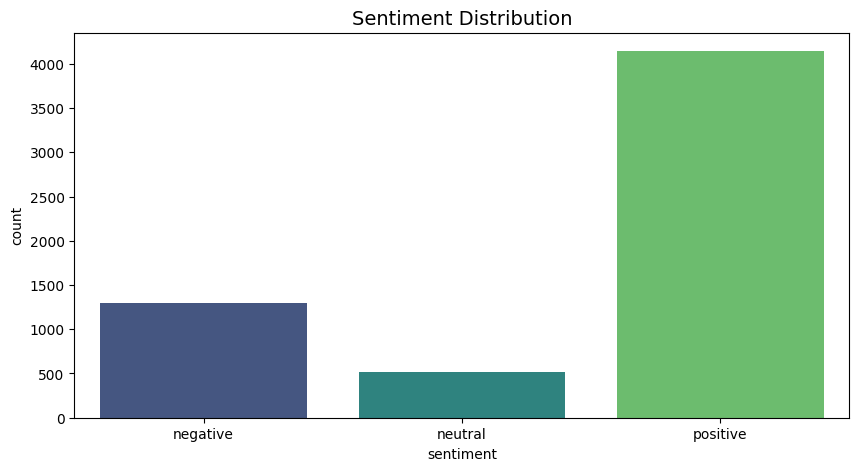

<ipython-input-10-c9751f0c4d22>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


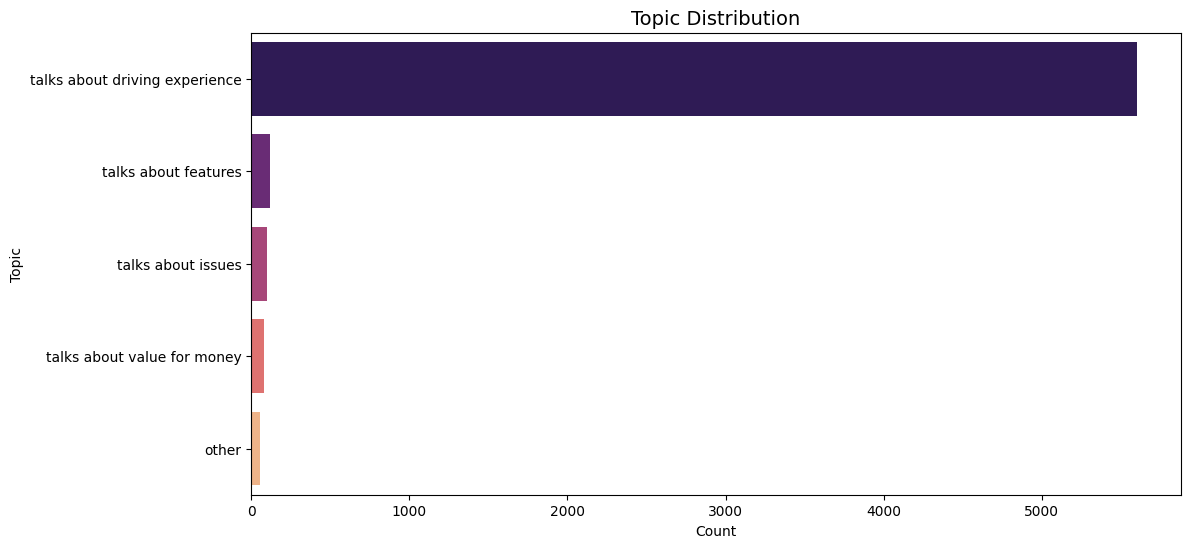

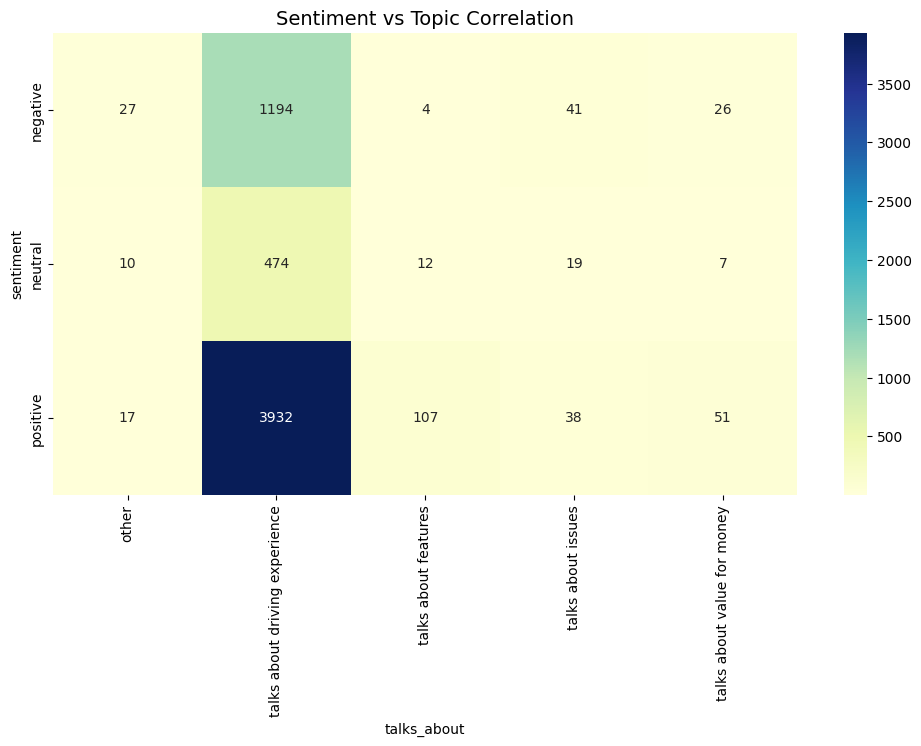

In [10]:
# Convert to DataFrame
df_final = dataset.to_pandas()

# Sentiment distribution
plt.figure(figsize=(10, 5))
sns.countplot(
    x="sentiment",
    data=df_final,
    order=["negative", "neutral", "positive"],
    palette="viridis"
)
plt.title("Sentiment Distribution", fontsize=14)
plt.show()

# Topic distribution
plt.figure(figsize=(12, 6))
sns.countplot(
    y="talks_about",
    data=df_final,
    order=df_final["talks_about"].value_counts().index,
    palette="magma"
)
plt.title("Topic Distribution", fontsize=14)
plt.xlabel("Count")
plt.ylabel("Topic")
plt.show()

# Cross-analysis
plt.figure(figsize=(12, 6))
sns.heatmap(
    pd.crosstab(df_final['sentiment'], df_final['talks_about']),
    annot=True,
    fmt="d",
    cmap="YlGnBu"
)
plt.title("Sentiment vs Topic Correlation", fontsize=14)
plt.show()

## Save Results

In [8]:
# Save Results
df_final.to_csv("analyzed_reviews.csv", index=False)
df_final.to_parquet("analyzed_reviews.parquet", index=False)

## Analysis


---


**1. Topic Distribution Analysis**

*Insights:*

*   Overwhelming focus is on the driving experience—about 80%+ of reviews. This shows that Kia customers are primarily commenting on how the car feels to drive (handling, comfort, performance, etc.).
*   Very few reviews talk about value for money, issues, or features in comparison. These may be secondary concerns for most users—or possibly underreported.
*   The "other" category is the smallest, meaning the label definitions captured most customer intent effectively.
\

**2. Sentiment vs. Topic Correlation**

*Key Observations:*

Driving Experience

*   3932 positive vs 1194 negative → Most users feel positively about how Kia cars drive.

*   That’s a 3.3:1 positive-to-negative ratio, indicating good driver satisfaction.

Features

*   Heavily skewed positive (107 positive vs 4 negative).

*   Users who mention features are generally happy with them—this could highlight areas like infotainment, safety, or connectivity that meet or exceed expectations.

Issues

*   More evenly split: 38 positive vs 41 negative, with 19 neutral.

*   This makes sense—this category inherently attracts more negative sentiment.

*   Actionable insight: Kia might review the content of these reviews to identify recurring complaints.

Value for Money

*   51 positive, 26 negative, 7 neutral.

*   Leaning positive, but only 84 reviews overall suggests many users don’t directly discuss pricing—or pricing satisfaction is taken for granted or isn't a pain point.

Other

*   Balanced: 27 negative, 17 positive, 10 neutral.

*   Hard to draw conclusions here without knowing what types of comments were categorized as “other.”

**3. Summary & Recommendations**

Product Strength

*   Kia is perceived very positively for its driving experience.

*   Features are also well-liked, though mentioned less often.

Opportunities for Improvement

*   A significant chunk of “driving experience” reviews are negative (1194)—this could be due to sub-models or inconsistent experience.

*   Issues are a relatively small category but skew negative. These could be valuable to examine closely in customer feedback analysis.